In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [2]:
#  experiments
from experiments.run_sweep import run_sweep
from experiments.run_experiment import TrainingConfig, EvaluateConfig
from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_plots_helpper import cliffwalking_training_plot_specs, cliffwalking_evaluation_plot_specs


# environments
from environments.cliffwalking import CliffWalkingConfig, get_cliffwalking_env

# SARSA confirmation bias agent
from agents.sarsa_td0_confirmation_bias import (
    SarsaTD0ConfirmationBiasConfig,
    SarsaTD0ConfirmationBiasAgent,
)

# metrics for training
from metrics.reward_mertrics import cliffwalking_reward_metrics_specs
from metrics.frustration_metrics import frustration_metrics_specs

# external libraries
import numpy as np

## Environments

In [3]:
env_config = CliffWalkingConfig()

## Agents

In [4]:
BASE_AGENT_CONFIG_CONF = dict(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=cliffwalking_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
    eval_every_episodes=10,  # every 5 training episodes
    mid_eval_episodes=20,  # run 1 eval episode
    max_eval_steps=200,  # safety cap for CliffWalking eval
    mid_eval_seed=0,
)

BASE_AGENT_CONFIG_POSITITY = dict(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=cliffwalking_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
    eval_every_episodes=10,  # every 5 training episodes
    mid_eval_episodes=20,  # run 1 eval episode
    max_eval_steps=200,  # safety cap for CliffWalking eval
    mid_eval_seed=0,
)

In [5]:
## Agents
# sarsa_td0 confirmation bias agent
agent_factory = SarsaTD0ConfirmationBiasAgent
sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(**BASE_AGENT_CONFIG_CONF)

## Sweep configuration

In [6]:
base_train = TrainingConfig(
    name="CliffWalking_sarsa_td0",
    num_train_episodes=10000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="CliffWalking_sarsa_td0",
    num_eval_episodes=100,  # use >0 if you want eval outputs
    env_kwargs={"config": env_config},
    evaluation_metrics=cliffwalking_reward_metrics_specs(),
)

## Confirmation bias results

In [7]:
def generate_alpha_pairs(
    balanced_lr: float | list[float], num_pairs: int, step_size: float
):
    lrs = balanced_lr if isinstance(balanced_lr, list) else [balanced_lr]

    all_confirmatory_pairs = []
    all_balanced_pairs = []
    all_disconfirmatory_pairs = []

    for lr in lrs:
        confirmatory_pairs = [
            (round(lr + k * step_size, 3), round(lr - k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]
        balanced_pairs = [(round(lr, 3), round(lr, 3))]
        disconfirmatory_pairs = [
            (round(lr - k * step_size, 3), round(lr + k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]

        # Highest confirmatory lr first
        confirmatory_pairs.sort(key=lambda p: p[0], reverse=True)

        all_confirmatory_pairs.extend(confirmatory_pairs)
        all_balanced_pairs.extend(balanced_pairs)
        all_disconfirmatory_pairs.extend(disconfirmatory_pairs)

    return all_confirmatory_pairs, all_balanced_pairs, all_disconfirmatory_pairs

In [ ]:
# different q_tables
env = get_cliffwalking_env(env_config)

# create different initial q_tables for the sweep
num_states = env.observation_space.n
num_actions = env.action_space.n

# q table initializations
q0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_pos = np.ones((num_states, num_actions), dtype=np.float64) * 100
q_neg = np.ones((num_states, num_actions), dtype=np.float64) * -100

q_tables = [("zeros", q0)]

confirmatory_pairs, balanced_pairs, disconfirmatory_pairs = generate_alpha_pairs(
    balanced_lr=[0.2],
    num_pairs=5,
    step_size=0.025,
)

alpha_pairs = confirmatory_pairs + balanced_pairs + disconfirmatory_pairs
seeds = list(range(1))  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "alpha_conf": a_conf,
            "alpha_disconf": a_disconf,
            "seed": seed,
#            "initial_q_table": q_table,
#            "initial_q_table_label": label,
        }
        for (a_conf, a_disconf) in alpha_pairs
#        for (label, q_table) in q_tables
        for seed in seeds
    ],
}

In [ ]:
# create different initial q_tables for the sweep
num_states = env.observation_space.n
num_actions = env.action_space.n

import pickle
from pathlib import Path

out_dir = Path("outputs/sweeps")
out_dir.mkdir(parents=True, exist_ok=True)

# q-table setup
q0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_tables = [("zeros", q0)]

# confirmation-bias alpha pairs
confirmatory_pairs, balanced_pairs, disconfirmatory_pairs = generate_alpha_pairs(
    balanced_lr=[0.2], num_pairs=5, step_size=0.025
)

# per your current setup: only balanced
alpha_pairs = balanced_pairs
seeds = list(range(15))

all_results = []
done_pairs = []

for a_conf, a_disconf in alpha_pairs:
    # safe file name for float values
    pair_tag = f"ac_{a_conf:.3f}_ad_{a_disconf:.3f}".replace(".", "p")
    out_file = out_dir / f"cliffwalking_conf_{pair_tag}.pkl"

    # resume behavior
    if out_file.exists():
        print(f"Skipping pair=({a_conf}, {a_disconf}) (already exists): {out_file}")
        with out_file.open("rb") as f:
            pair_results = pickle.load(f)
        all_results.extend(pair_results)
        done_pairs.append((a_conf, a_disconf))
        continue

    sweep_one_pair = {
        "agent_kwargs": [
            {
                "alpha_conf": a_conf,
                "alpha_disconf": a_disconf,
                "seed": seed,
                "initial_q_table": q_table,
                "initial_q_table_label": label,
            }
            for (label, q_table) in q_tables
            for seed in seeds
        ],
    }

    print(
        f"Running CliffWalking pair=({a_conf}, {a_disconf}) with {len(seeds)} seeds..."
    )
    pair_results = run_sweep(
        base_training=base_train,
        base_evaluation=base_eval,
        sweep=sweep_one_pair,
        env_factory=get_cliffwalking_env,
        agent_factory=agent_factory,
    )

    # save immediately
    with out_file.open("wb") as f:
        pickle.dump(pair_results, f)

    all_results.extend(pair_results)
    done_pairs.append((a_conf, a_disconf))
    print(f"Saved pair=({a_conf}, {a_disconf}) -> {out_file}")

# optional combined file
# combined_file = out_dir / "cliffwalking_conf_all_pairs.pkl"
# with combined_file.open("wb") as f:
#     pickle.dump(all_results, f)

print(f"Done pairs: {len(done_pairs)} / {len(alpha_pairs)}")
print(f"Total runs collected: {len(all_results)}")
# print(f"Combined saved to: {combined_file}")

In [11]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_cliffwalking_env,
    agent_factory=agent_factory,
)


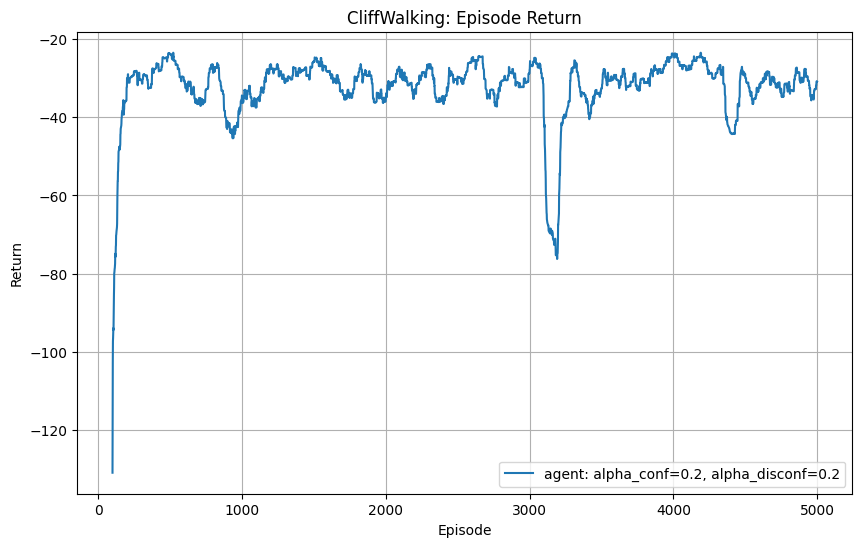

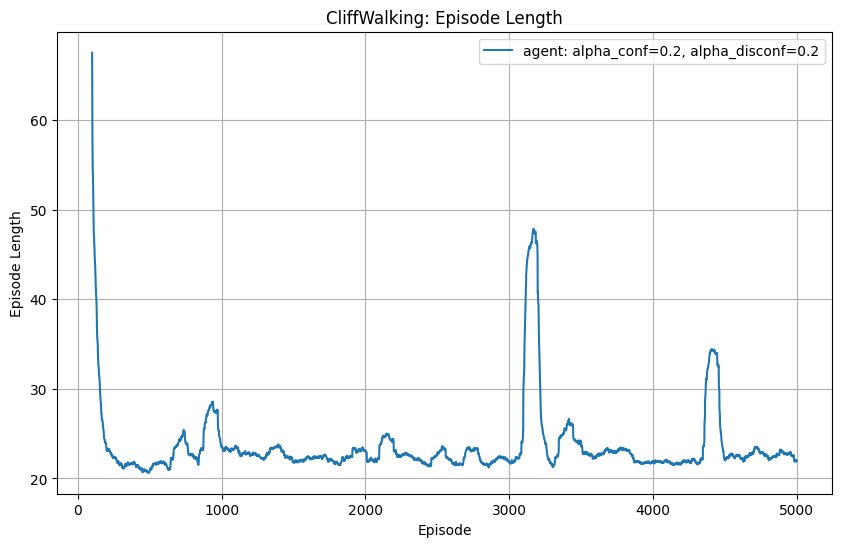

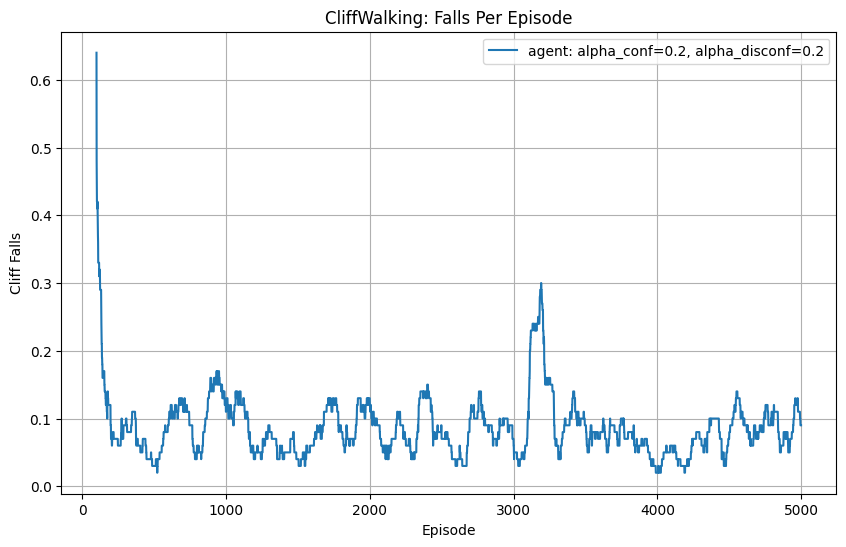

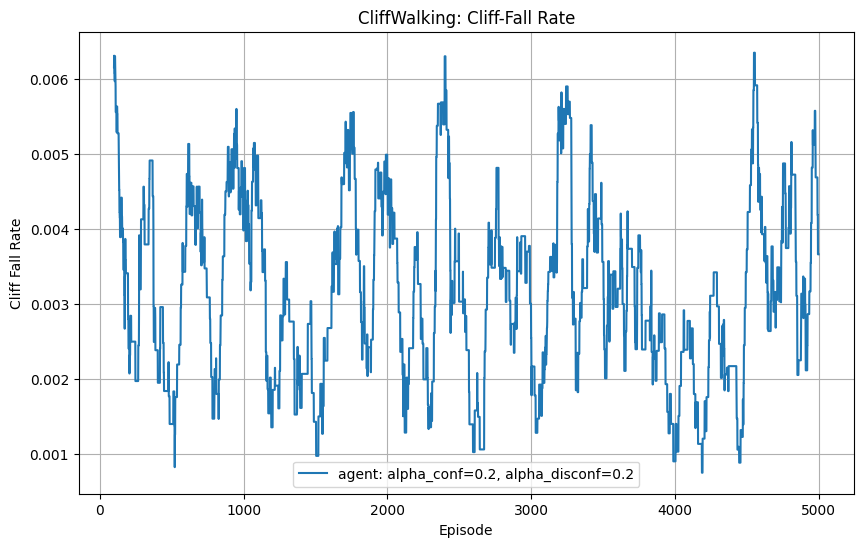

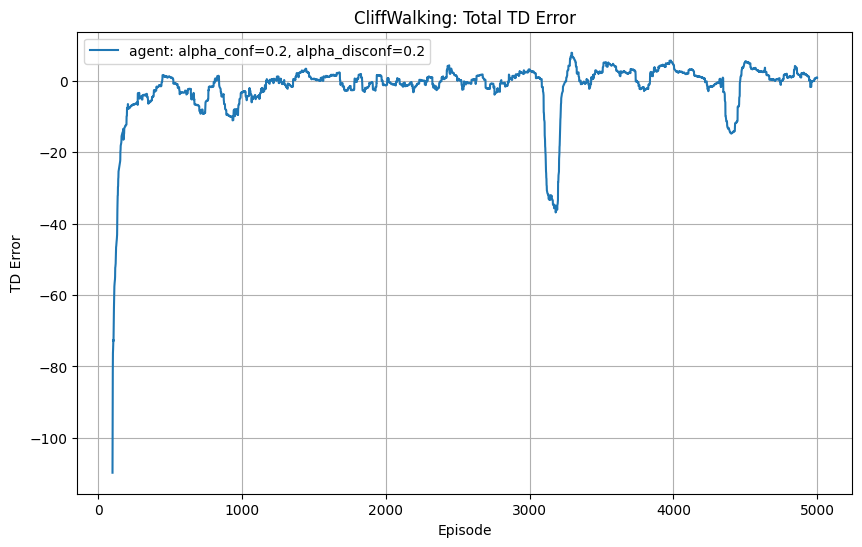

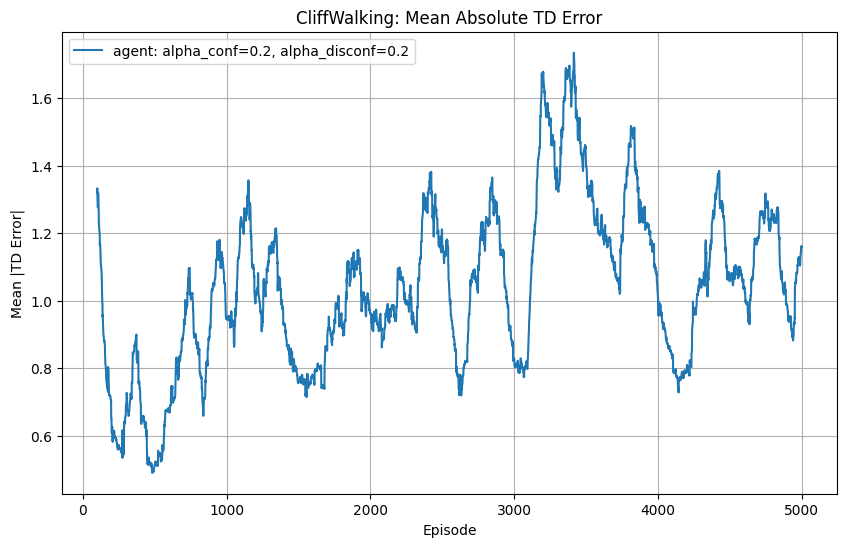

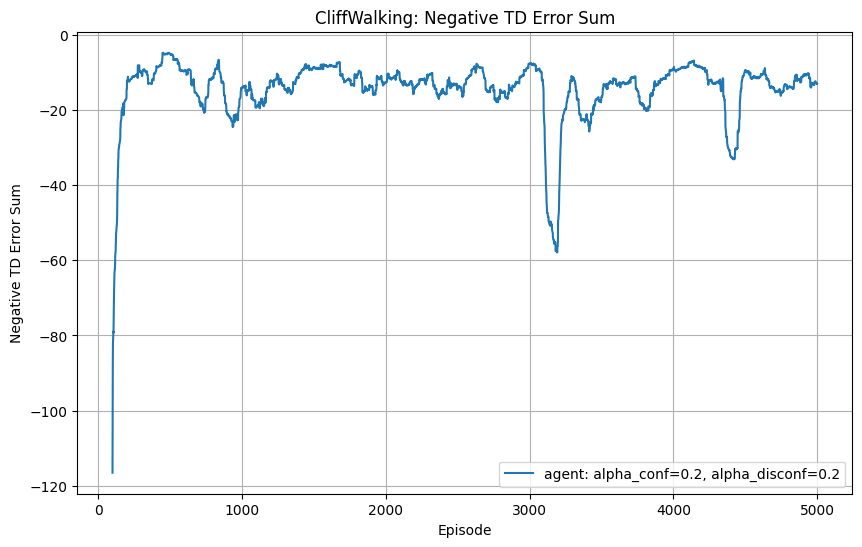

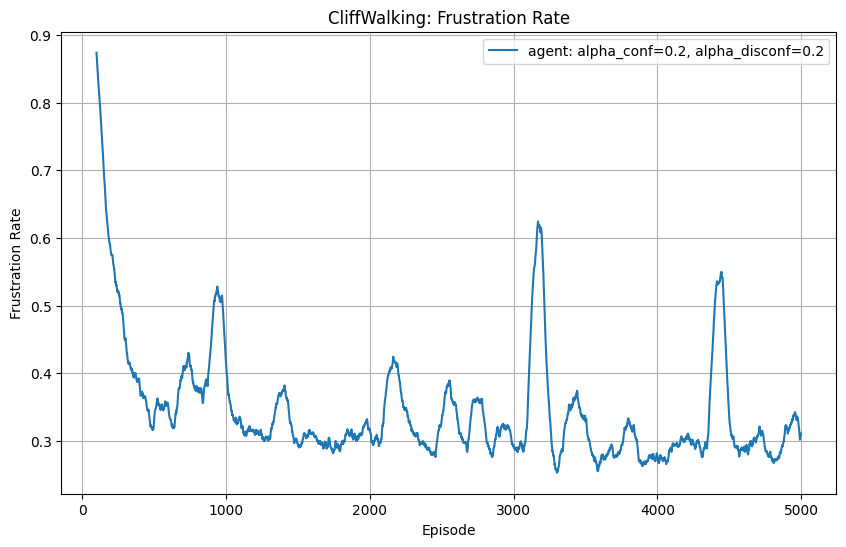

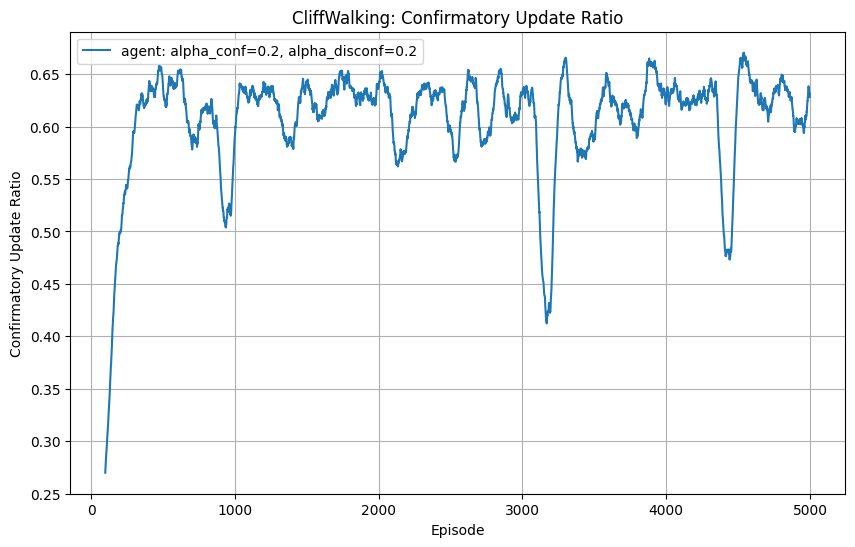

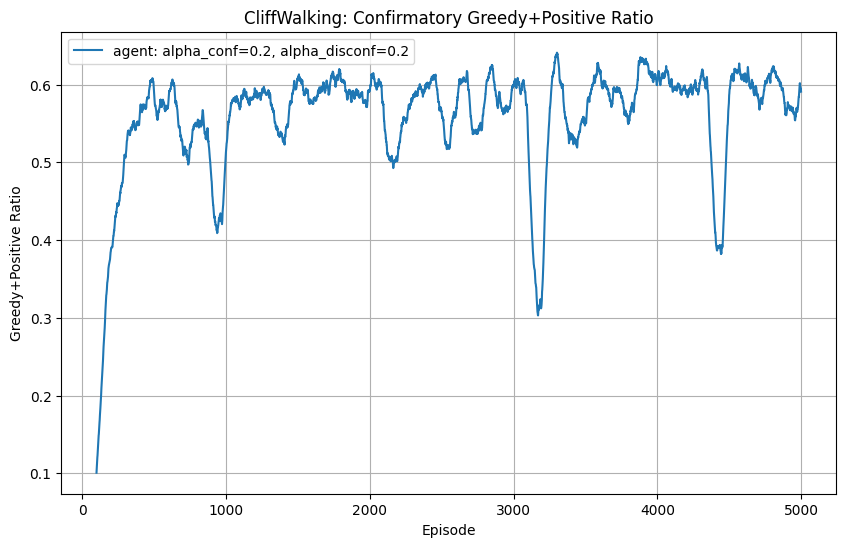

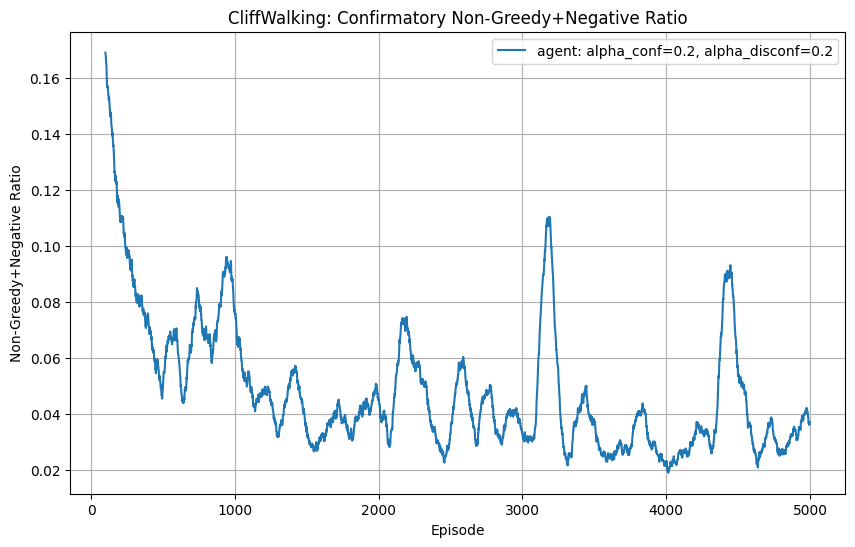

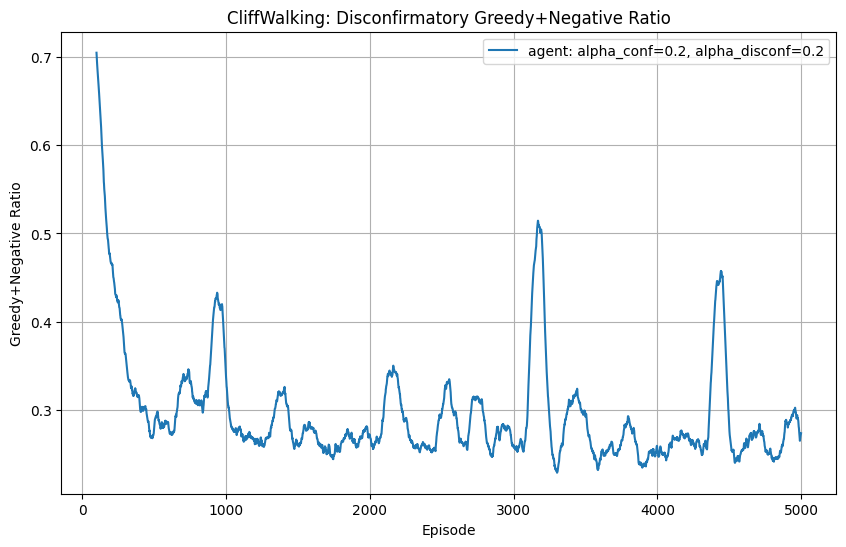

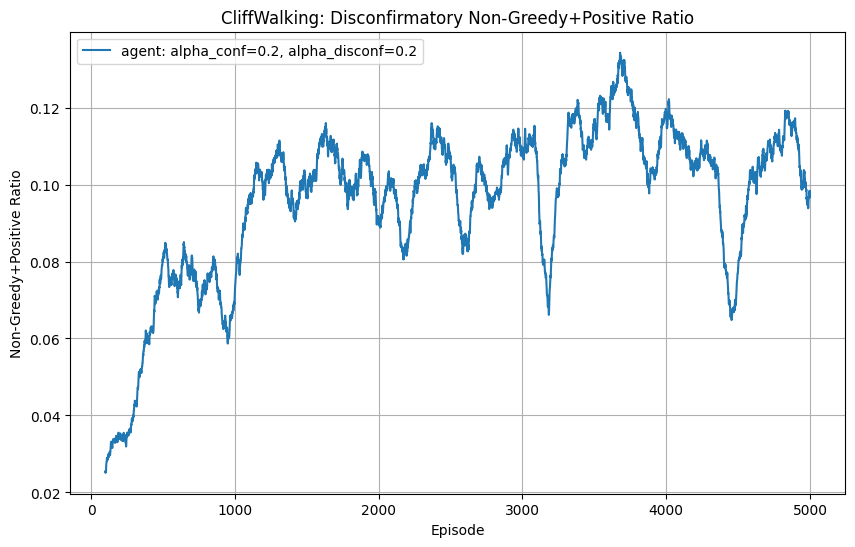

In [12]:
plot_sweep_training(
    results,
    window_size=100,
    start_episode=0,
    end_episode=5000,
    plot_specs=cliffwalking_training_plot_specs(),
)

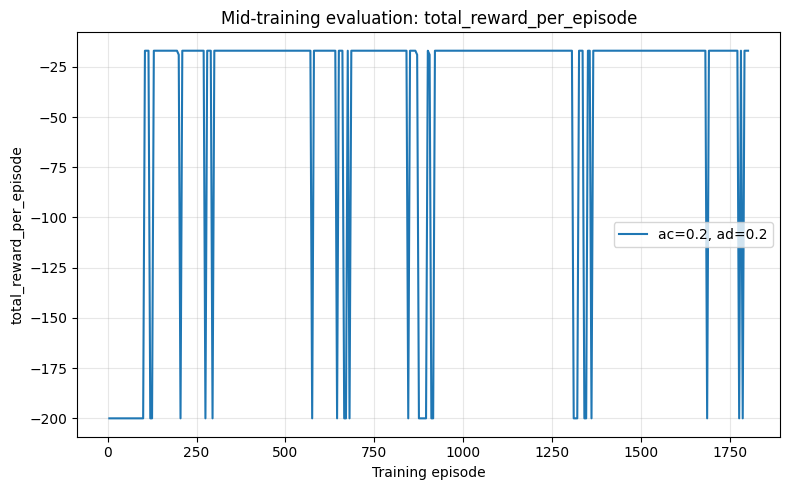

In [14]:
# mid eval plotting
from plots.plots import plot_mid_eval_metric

plot_mid_eval_metric(results, max_points_from_start=360)

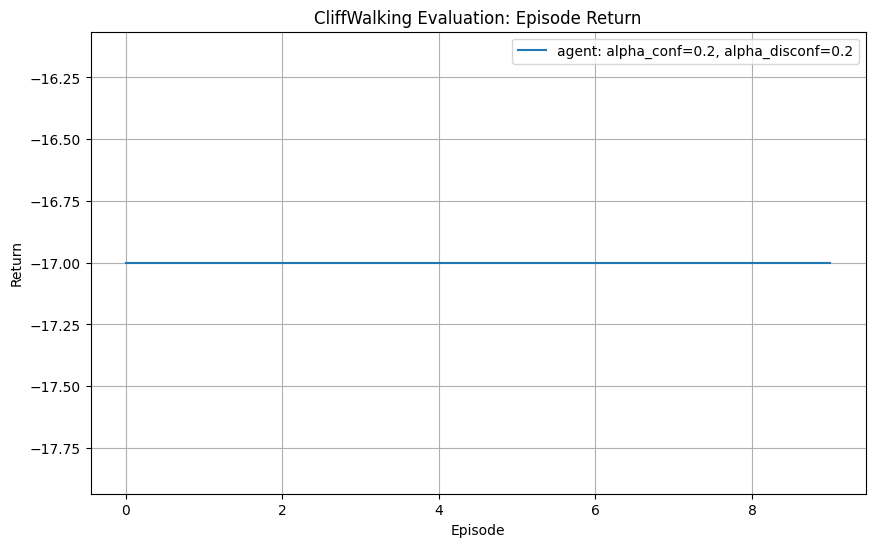

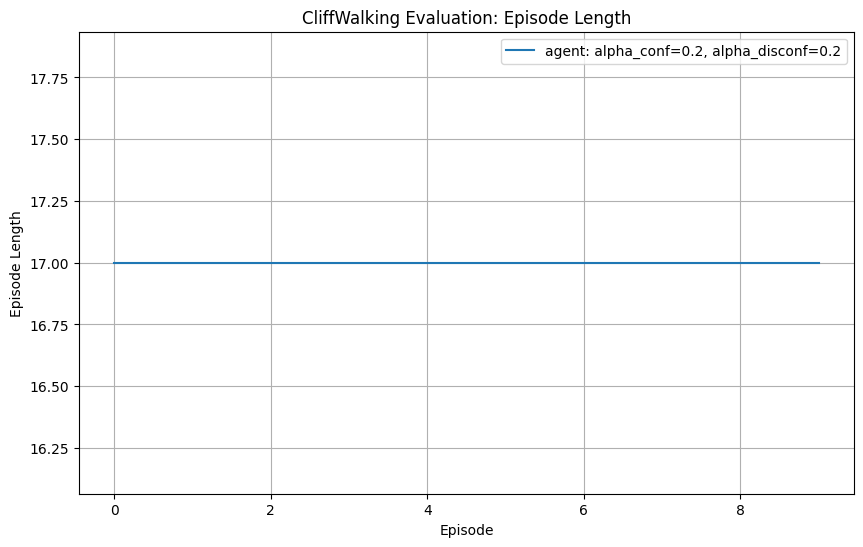

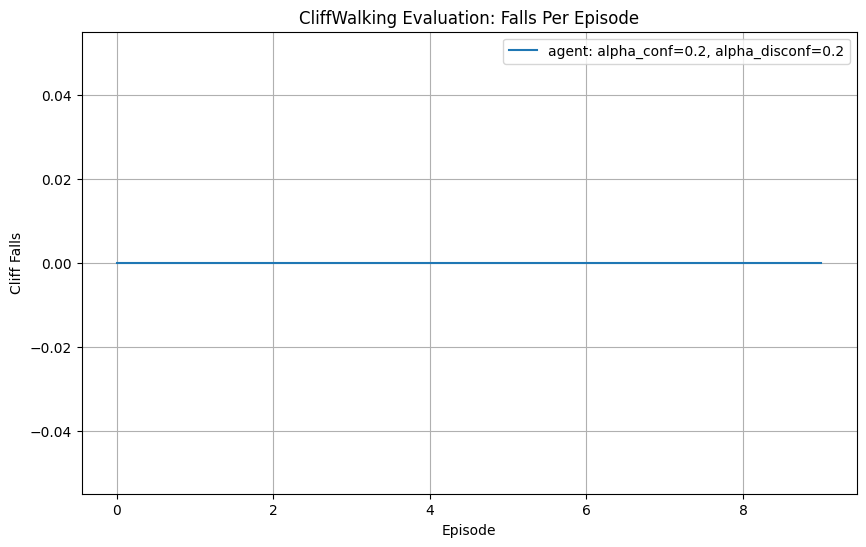

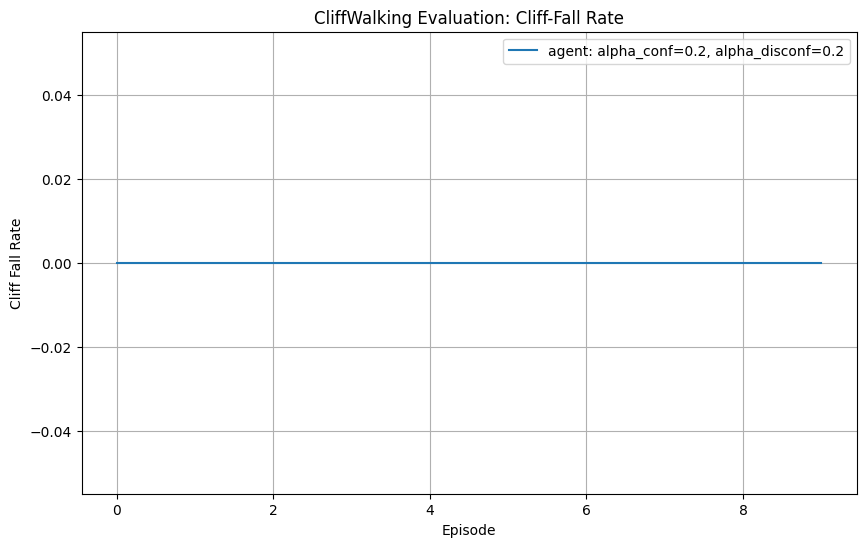

In [15]:
plot_sweep_evaluation(
    results=results,
    window_size=1,
    plot_specs=cliffwalking_evaluation_plot_specs(),
)

In [ ]:
# compare td_error vs td_error_v moving averages for one run
from plots.archive.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


## Positivity bias results

In [ ]:
# SARSA positivty bias agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0PositivityBiasConfig,
    SarsaTD0PositivityBiasAgent,
)

In [ ]:
def asymmetric_alphas(alpha_0: float, ratio: float) -> dict:
    """Return asymmetric step-sizes with a fixed mean and ratio."""
    if alpha_0 <= 0 or ratio <= 0:
        raise ValueError("alpha_0 and ratio must be > 0")

    alpha_negative = round((2.0 * alpha_0) / (ratio + 1.0), 4)
    alpha_positive = round(
        ratio * alpha_negative, 4
    )  # same as 2*alpha_0*ratio/(ratio+1)

    return {"alpha_positive": alpha_positive, "alpha_negative": alpha_negative}

In [ ]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0PositivityBiasAgent
reward_metrics_specs = ()

sarsa_td0_config = SarsaTD0PositivityBiasConfig(**BASE_AGENT_CONFIG_POSITITY)

In [ ]:
base_train = TrainingConfig(
    name="TaxiV3_sarsa_td0",
    num_train_episodes=10000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="TaxiV3_sarsa_td0",
    num_eval_episodes=0,
    env_kwargs={"config": env_config},
    evaluation_metrics=cliffwalking_reward_metrics_specs(),
)

In [ ]:
# different q_tables
env = get_cliffwalking_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [ ]:
# mean alpha_0 = 0.2
a_0 = 0.2
ratios = [0.5, 0.75, 1.0, 1.5, 2.0, 4.0]

seeds = list(range(5))

sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for r in ratios
        for seed in seeds
    ],
}

In [ ]:
# create different initial q_tables for the sweep
num_states = env.observation_space.n
num_actions = env.action_space.n

import pickle
from pathlib import Path

out_dir = Path("outputs/sweeps")
out_dir.mkdir(parents=True, exist_ok=True)

# q-table setup
q0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_tables = [("zeros", q0)]

# positivity-bias ratios
a_0 = 0.2
ratios = [0.5, 0.75, 1.0, 1.5, 2.0, 4.0]
seeds = list(range(15))

all_results = []
done_ratios = []

for r in ratios:
    ratio_tag = str(r).replace(".", "p")
    out_file = out_dir / f"cliffwalking_pos_ratio_{ratio_tag}.pkl"

    # resume behavior
    if out_file.exists():
        print(f"Skipping ratio={r} (already exists): {out_file}")
        with out_file.open("rb") as f:
            ratio_results = pickle.load(f)
        all_results.extend(ratio_results)
        done_ratios.append(r)
        continue

    sweep_one_ratio = {
        "agent_kwargs": [
            {
                **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
                "seed": seed,
                "initial_q_table": q_table,
                "initial_q_table_label": label,
            }
            for (label, q_table) in q_tables
            for seed in seeds
        ],
    }

    print(f"Running CliffWalking ratio={r} with {len(seeds)} seeds...")
    ratio_results = run_sweep(
        base_training=base_train,
        base_evaluation=base_eval,
        sweep=sweep_one_ratio,
        env_factory=get_cliffwalking_env,
        agent_factory=agent_factory,
    )

    # save immediately
    with out_file.open("wb") as f:
        pickle.dump(ratio_results, f)

    all_results.extend(ratio_results)
    done_ratios.append(r)
    print(f"Saved ratio={r} -> {out_file}")

# optional combined file
# combined_file = out_dir / "cliffwalking_pos_all_ratios.pkl"
# with combined_file.open("wb") as f:
#     pickle.dump(all_results, f)

print(f"Done ratios: {len(done_ratios)} / {len(ratios)}")
print(f"Total runs collected: {len(all_results)}")
# print(f"Combined saved to: {combined_file}")

In [ ]:
results_positivity = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_cliffwalking_env,
    agent_factory=agent_factory,
)

In [ ]:
# around alpha_0 = 0.2, step size 0.025, ratio fixed to 1.0
a_0_center = 0.2
step = 0.025
n_steps_each_side = 2  # gives 5 rates total
ratio = 1.0
seeds = list(range(5))

learning_rates = [
    round(a_0_center + k * step, 3)
    for k in range(-n_steps_each_side, n_steps_each_side + 1)
]
# -> [0.15, 0.175, 0.2, 0.225, 0.25]

sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(alpha_0, ratio),  # alpha_positive == alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for alpha_0 in learning_rates
        for seed in seeds
    ],
}

In [ ]:
result_positivity = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_cliffwalking_env,
    agent_factory=agent_factory,
)

In [ ]:
plot_sweep_training(
    result_positivity,
    start_episode=0,
    end_episode=4000,
    window_size=400,
    plot_specs=cliffwalking_training_plot_specs(),
)

In [ ]:
plot_sweep_evaluation(results, window_size=100, plot_specs=cliffwalking_evaluation_plot_specs())

In [ ]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)